In [ ]:
# Name: Manoj Kumar Jaiswal
# Email: mkjaiswa@eng.ucsd.edu
# PID A53106952

In [2]:
%pwd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data_dir = "../Data/Weather/"
%matplotlib inline
!mkdir -p $data_dir
!ls $data_dir

STAT.pickle                 data-source.txt             ghcnd-stations.txt          ghcnd-version.txt
SampleStations.pickle       ghcnd-readme.txt            ghcnd-stations_buffered.txt stations.pkl


### Downloading Pickled data from S3
If `SampleStations.pickle` is not in the directory, get it using the following command

In [4]:
# Download the DataFile
#!curl -o $data_dir/SampleStations.pickle http://mas-dse-open.s3.amazonaws.com/Weather/SampleStations.pickle

### Plot Reconstructions

From each measurement, we take 2 sample stations with low residual error and 2 sample stations with high residual error and plot the following:

* Original Data Vector
* Mean Vector
* Reconstructed Data Vector using mean and top 1 eigen vectors
* Reconstructed Data Vector using mean and top 2 eigen vectors
* Reconstructed Data Vector using mean and top 3 eigen vectors

### Read and Preprocess data

Read data from the pickle files `SampleStations.pickle` and `STAT.pickle`

* `SampleStations.pickle` contains information about the 6 measurements taken from some sample stations. You have been provided the code to process this file. It converts the seemingly complicated structure into a list of lists where each sublist has the following information:

`['station','measurement','year','1', '2', '3', ...... , '365']`

*  station - The station ID
*  measurement - One of the 6 types of measurements
*  year - The year in which the measurements were recorded
*  1-365 - The actual value of measurement for each day of the year



* `STAT.pickle` contains statistics about the weather data for each of the 6 measurements and its description.

In [5]:
import pickle
Data=pickle.load(open('../Data/Weather/SampleStations.pickle','r'))
STAT,STAT_description=pickle.load(open('../Data/Weather/STAT.pickle','r'))

In [6]:
FlatData=[]
for station in Data:
    stationname=station[0]
    for measurements in station[1]:
        measurement,year=measurements[0]
        yeardata=list(measurements[1])
        rowData=[stationname]+[measurement]+[year]+yeardata
        FlatData.append(rowData)

In [7]:
import pandas as pd

frameheader=['station','measurement','year']+range(1,366)
df=pd.DataFrame(FlatData,columns=frameheader)

m_df={}
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    t_df=df[df['measurement']==m]
    m_df[m]=t_df    

In [8]:
df.head()

,station,measurement,year,1,2,3,4,5,6,7,...,356,357,358,359,360,361,362,363,364,365
0,US1INMR0064,PRCP,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,8,8,NaN,5,NaN,NaN,0,0,30
1,US1INMR0064,PRCP,2010,0,0,0,3,3,0,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1INMR0064,PRCP,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0,0,NaN,0,86,NaN,NaN,NaN,71
3,US1INMR0064,PRCP,2012,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1INMR0064,PRCP,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define Reconstruction Function

You need to plot reconstructions for two stations with low reconstruction error and two stations with high reconstruction error. To do this, you will need to do the following:

1. Calculate the reconstruction error for the data vector reconstructed using mean and top-3 eigenvectors.
2. Remove the ones for which reconstruction error is NaN.
3. Choose two with the lowest and two with the highest reconstruction error for plotting.

### PCA reconstuction

$$
Reconstruction = mean + U * U^T * \left( x - mean \right)
$$

- U is the eigen vector matrix in which each column is an eigen vector

- x is a test vector

In [9]:
def get_reconstruction(data_matrix, eigen_matrix_U, data_mean):
    # Normalize the data to have 0 mean.
    mean_normalized_data = data_matrix - data_mean

    reconstruction = np.dot(np.dot(eigen_matrix_U, np.transpose(eigen_matrix_U)), np.transpose(mean_normalized_data))
    reconstruction = np.transpose(reconstruction) + data_mean
    return reconstruction

In [10]:
def create_reconstructions(m):  
    
    ## Put your code for computating reconstructions here
    
    # Get the original data
    df_measure_data = m_df[m].iloc[:, 3:]
    
    # Get the indices that will sort the eigen values and take top 3 eigen values.
    indices = STAT[m]['eigval'].argsort()[::-1][:3]
    
    # reconstruct the data.
    reconstruction = get_reconstruction(df_measure_data.values, STAT[m]['eigvec'][:, indices], STAT[m]['Mean'])
    
    # Calculate the Squared error.
    error = np.power(df_measure_data.values - reconstruction, 2).sum(axis=1)
    
    # assign the Squared error to the data frame
    df_measure_data = df_measure_data.assign(squared_error=error)
    
    # Filter the rows without NaNs in squared_error column.
    sorted_data = df_measure_data[~df_measure_data.squared_error.isnull()].sort_values(by='squared_error')
    
    # Remove the last column (squared_error) to get the original data.
    original = sorted_data.iloc[:, :-1].values
    
    Reconstructed = [0]
    for i in range(1, 4):
        # Append the reconstructed vectors to list.
        Reconstructed.append(get_reconstruction(original,
                STAT[m]['eigvec'][:, indices[:i]], STAT[m]['Mean']))    
    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,30), dpi=300)
    j=1
    c=0   
    
    lower = [0, 1]
    for l in lower:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][l])
        plot(Reconstructed[2][l])
        plot(Reconstructed[3][l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0,365])
        legend(['original','Mean','1','2','3'],loc=2)

    upper = [-2, -1]
    c=0
    for l in upper:
        subplot(4, 2, j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][l])
        plot(Reconstructed[2][l])
        plot(Reconstructed[3][l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0,365])
        legend(['original','Mean','1','2','3'],loc=2)

Reconstruction Plots for TMAX
Reconstruction Plots for SNWD


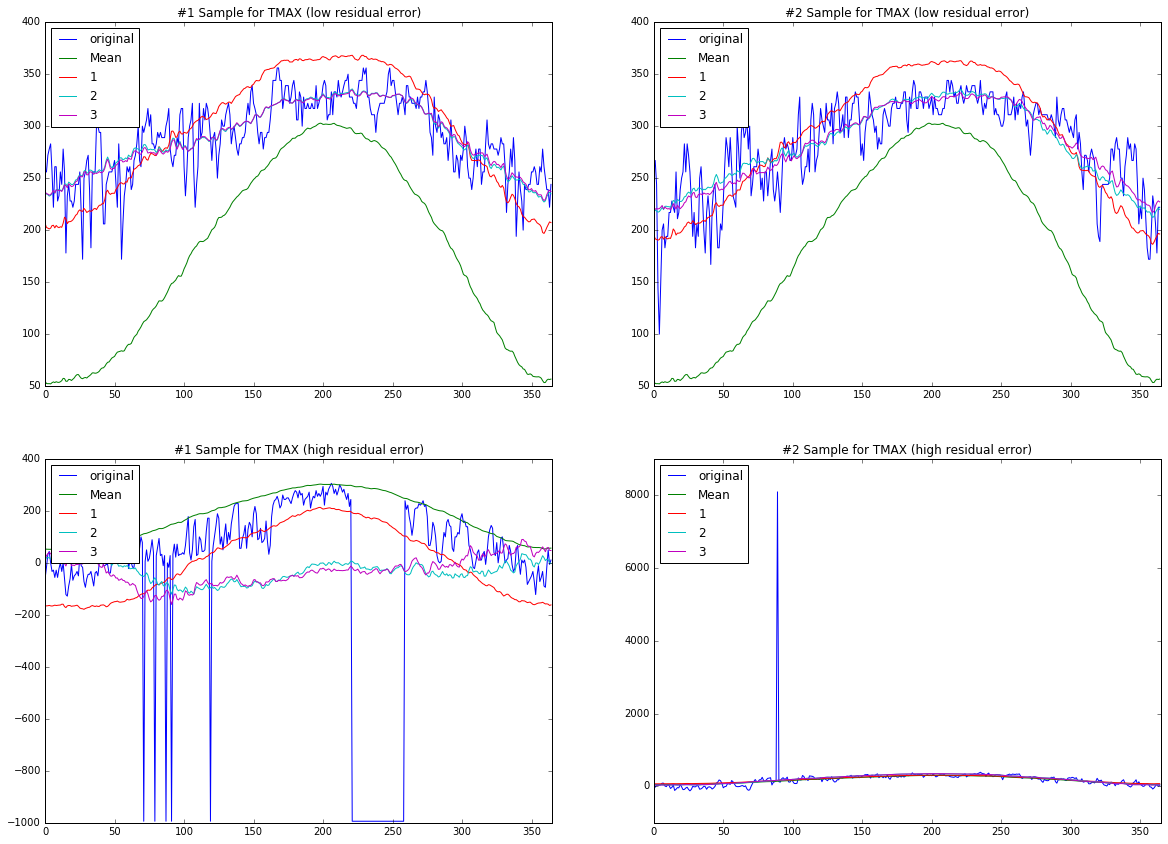

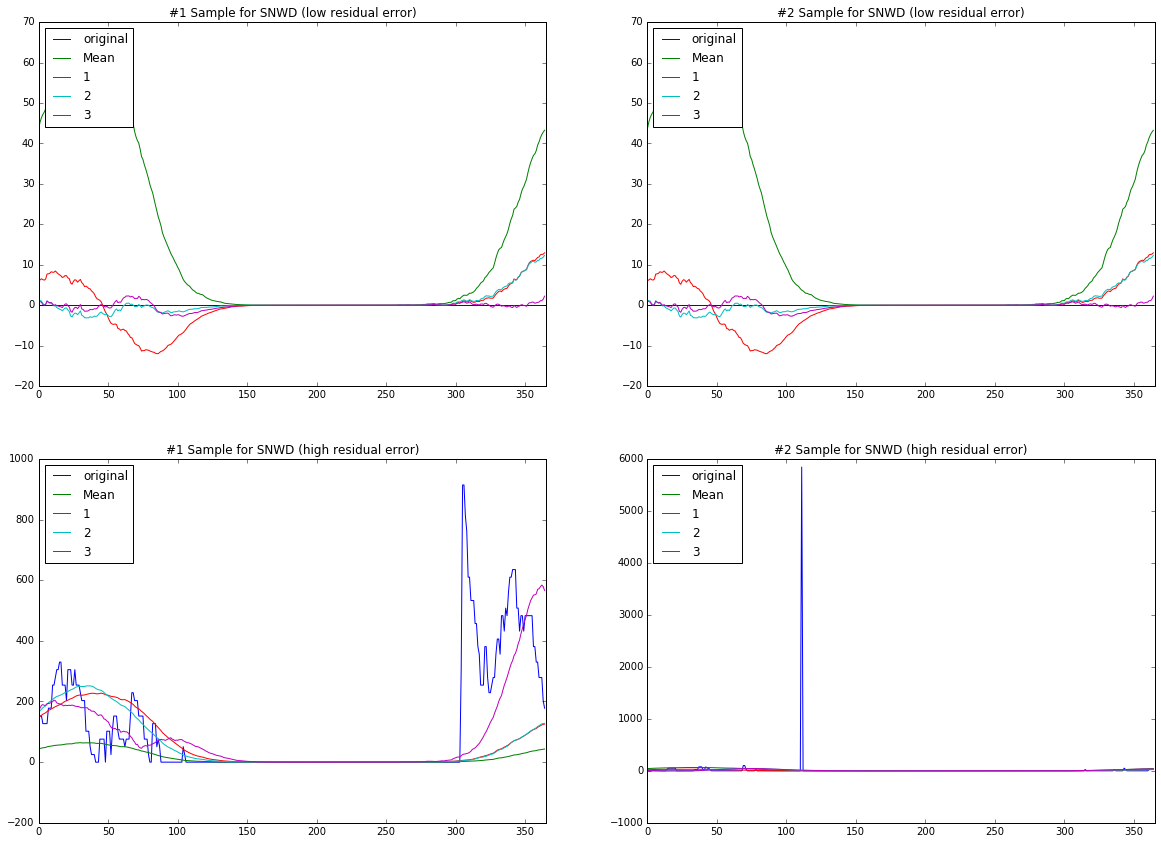

In [11]:
for m in ['TMAX','SNWD']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)